In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


## Prepare aging data to work with
- We divide the data by the starting value, so the values are R/R_0 relative degredation to initial value
- Then we invert to get to conductances 
- Now we normalize the livetime to $(t_0, t_1) = [0,1]$ from 0 , 37  as t0 and t1

In [2]:
data = pd.read_csv('group2.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data['days'] = data.index
data.days = data.days.diff().dt.days
data.days = data.days.fillna(0).cumsum()
#data.index = pd.to_datetime(data.index)
data.index=data.days
data = data.drop('days', axis=1)
data.head()

,Res_0,Res_1,Res_2,Res_3,Res_4,Res_5
days,,,,,,
0.0,15681.818182,10000.000000,11785.714286,14166.666667,17500.000000,14166.666667
1.0,16730.769231,11785.714286,11785.714286,15681.818182,18776.595745,15681.818182
2.0,17500.000000,12425.373134,12884.615385,17500.000000,19722.222222,16730.769231
3.0,19722.222222,13629.032258,14166.666667,19722.222222,22500.000000,17500.000000
6.0,21309.523810,14166.666667,15681.818182,22500.000000,23815.789474,18776.595745


In [3]:
data = data/data.min() # ratio to initial value
data = 1/data
data.index = data.index/data.index.max()
data.columns = ['Cond_{}'.format(i) for i in range(data.shape[1])]
data

,Cond_0,Cond_1,Cond_2,Cond_3,Cond_4,Cond_5
days,,,,,,
0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.027027,0.937304,0.848485,1.000000,0.903382,0.932011,0.903382
0.054054,0.896104,0.804805,0.914712,0.809524,0.887324,0.846743
0.081081,0.795134,0.733728,0.831933,0.718310,0.777778,0.809524
0.162162,0.735907,0.705882,0.751553,0.629630,0.734807,0.754485
0.243243,0.696970,0.637681,0.751553,0.629630,0.671233,0.718310
0.432432,0.601494,0.604317,0.673469,0.629630,0.619048,0.673660
0.621622,0.545455,0.571429,0.642857,0.543379,0.608696,0.664804
1.000000,0.508600,0.444444,0.523810,0.426523,0.567568,0.629630


# Fit Model

In [4]:
from scipy.optimize import curve_fit
from scipy.special import comb

def get_piecewise_linear(x, *params):
    ''' 
    Just two lines segments max
    '''
    
    m0, m1, b1 = params
    b0 = 1
    
    mod = lambda z : max(z*m0 + b0, z*m1 + b1)
    
    return np.array([mod(xi) for xi in x])

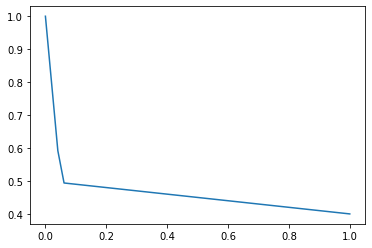

In [6]:
p0 = np.array([-10, -.1, .5])
vals = np.linspace(0,1)
plt.plot(vals, get_piecewise_linear(vals, *p0));

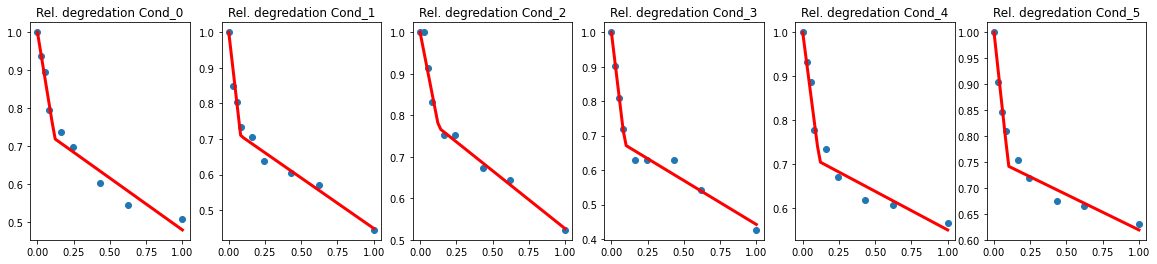

In [7]:
fig, ax = plt.subplots(ncols = len(data.columns), figsize=(20,4))

# bounds and starting value for fitting
p0 = np.array([-10, -.1, .5]) # np.array([-2, -1, -3])  # <--------------------- the more numbers you put there the more params you have !
bnds = [[-np.inf, -np.inf, -np.inf], [0, 0, 1]]
#bnds = list(zip(*[(-np.inf, 0)]*len(p0)))

param_sets = []
for i, c in enumerate(data.columns):
    
    x,y = data.index, data[c]
    ax[i].scatter(data.index, data[c])
    
    re =curve_fit(get_piecewise_linear, xdata=x, ydata=y, p0=p0, maxfev=2000, bounds=bnds)[0]
    ax[i].plot(vals, get_piecewise_linear(vals, *re), c='red', lw=3)
    ax[i].set_title('Rel. degredation '+c)
    p0 = re
    param_sets.append(re)

# Model the parameter distribution
- Model the param sets with some distribution model, very simple independent sampling for now

In [8]:
param_data = pd.DataFrame(param_sets, columns = ['m0', 'm1', 'b1'])
params_scales = param_data.std()
params_scales[param_data.max(0) < 0.001] = 0.
param_data

,m0,m1,b1
0,-2.339153,-0.272843,0.751894
1,-3.543337,-0.283429,0.732167
2,-1.783340,-0.278735,0.805756
3,-3.495552,-0.254715,0.697051
4,-2.537163,-0.175123,0.726412
5,-2.575624,-0.136441,0.755292


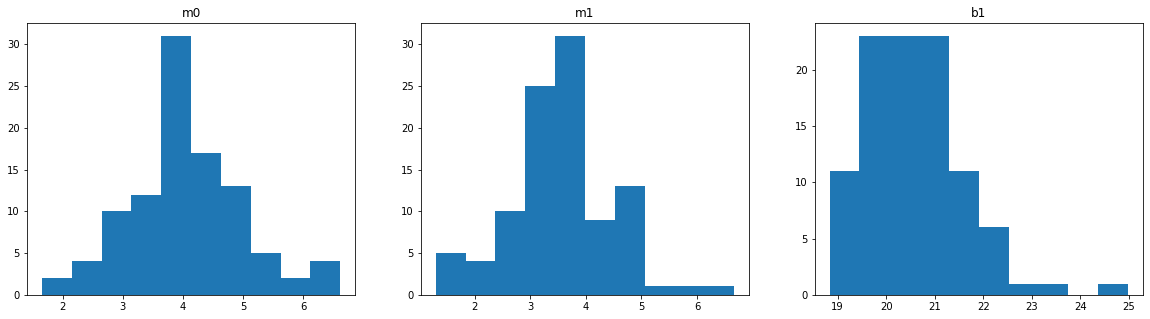

In [9]:
from scipy.stats import norm, chi2, lognorm

# maybe tranform them into a certain range and then invert them ? 

# some positive distribution to model the parameters
base_dist = lognorm # chi2 # lognorm #   <--------------------------------------------- can try different ones here 
dists = {c : base_dist(*base_dist.fit(param_data[c].abs()/param_data[c].std())) for c in param_data.columns}

fig, ax = plt.subplots(1, param_data.shape[1], figsize=(20,5))
for i, c in enumerate(param_data.columns):
    ax[i].hist(dists[c].rvs(100))
    ax[i].set_title(c)

# Draw samples 

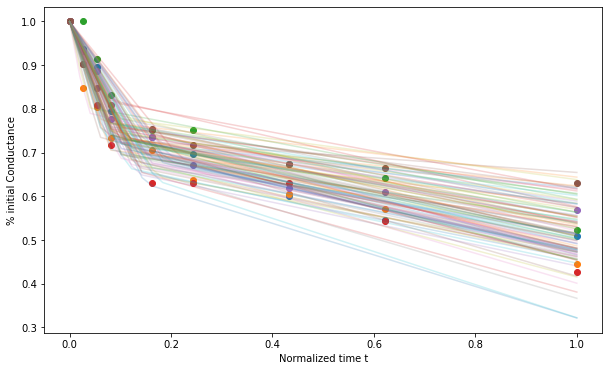

In [10]:
plt.figure(figsize=(10, 6))
plt.xlabel('Normalized time t')
plt.ylabel('% initial Conductance')

def get_param_sample():
    ''' samples from the param distributions '''
    return np.array([dists[c].rvs(1)*param_data[c].std() for c in param_data.columns]).ravel()

def transform_sample(x):
    ''' negates first entries '''
    return np.r_[-x[:-1], x[-1]]

np.random.seed(2)
for i in range(100):
    plt.plot(vals, get_piecewise_linear(vals, *transform_sample(get_param_sample())) , alpha=.2, )

for i, c in enumerate(data.columns):
    x,y = data.index, data[c]
    plt.scatter(data.index, data[c])
    

# Aging model generator

In [16]:
param_data

,m0,m1,b1
0,-2.339153,-0.272843,0.751894
1,-3.543337,-0.283429,0.732167
2,-1.783340,-0.278735,0.805756
3,-3.495552,-0.254715,0.697051
4,-2.537163,-0.175123,0.726412
5,-2.575624,-0.136441,0.755292


## Aging aware training

$$ \min_\theta \quad \int_{t=0}^{1} \; L(\theta(t)) \; dt $$
where  $\theta(t)$ is a fitted model of the conductance over time

### MC approximation:

$$ \int f(x) p(x) dx = E_{p(x)}[f(x)] \approx \frac{1}{n} \sum_i f(x_i) \quad x_i \sim p(x) $$

$$ \int f(x) dx  = \int f(x)  \cdot 1 dx  = \int f(x) \frac{q(x)}{q(x)} dx  = \int \frac{f(x)}{q(x)} \cdot q(x) dx $$

$$  \int \frac{f(x)}{q(x)} \cdot q(x) dx = E_{q(x)} [  \frac{f(x)}{q(x)}] \approx \frac{1}{n} \sum_i  \frac{f(x_i)}{q(x_i)} \quad x_i \sim q(x)  $$

$q(x) = ? -> q(x) = \mathcal{U}[0,1]$

$$ \approx \frac{1}{n} \frac{1}{q(x)} \sum_i  f(x_i)   $$

$$ \approx \frac{1}{n} \sum_i  f(x_i)  \quad x_i \sim q(x)$$

Gradient:

$$ \approx \frac{1}{n} \sum_i \nabla_x f(x_i)  \quad x_i \sim q(x)$$


Problem:

$$ \min_x  \quad E_{q(x)}[f(x)] $$


$$ \theta(t) = \theta^{init} \cdot \operatorname{AgingModel}(t) $$

$$\nabla_{\theta^{init}}$$


$$ \nabla L(\theta(t))  = \nabla L(\theta(t)) \nabla \theta(t) $$

In [ ]:
self.theta_
self.time = 

@property
def theta(self):
    return st(self.theta_time)

@property
def theta_time(self):
    return theta * agingmodel(self.t)

In [ ]:
# accumulate gradients for different values of t
net.zero_grad()
for t in ranget:
    net.time = t
    prediction = net(x)
    loss = lossf(prediction, true)
    loss.backward() # accuulation + grad caluclation
    
for p in net.parameters():
    p.grad /= len(ranget)
    
optimizer.step()
